In [1]:
import re
import pandas as pd
import uncertainties as un
import uncertainties.unumpy as unp
import numpy as np
import matplotlib.pyplot as plt

idx = pd.IndexSlice

plt.rcParams['axes.labelsize'] = 'large'
nom = unp.nominal_values
std = unp.std_devs

from latools.helpers.stat_fns import gauss_weighted_stats

# Load Data

In [2]:
# read data
nd = pd.read_csv('data/raw_Neptune_stripped.csv')
# parse datetime
nd.loc[:, 'datetime'] = pd.to_datetime(nd.loc[:, 'Date'] + ' ' + nd.loc[:, 'Time'], format='%d/%m/%y %H:%M:%S')

# calculate minute timescale for each run
nd.loc[:, 'run_minutes'] = 0
for k, g in nd.groupby('Run'):
    nd.loc[nd.Run == k, 'run_minutes'] = (g.datetime - g.datetime.min()).dt.total_seconds() / 60

In [3]:
iblank = nd.Sample == 'Blank'
iwash = nd.Sample == 'Wash'
iLSVEC = nd.Sample.str.contains('SVEC')
iext = nd.Sample.str.contains('ext')
isample = ~(iblank ^ iwash ^ iLSVEC ^ iext)

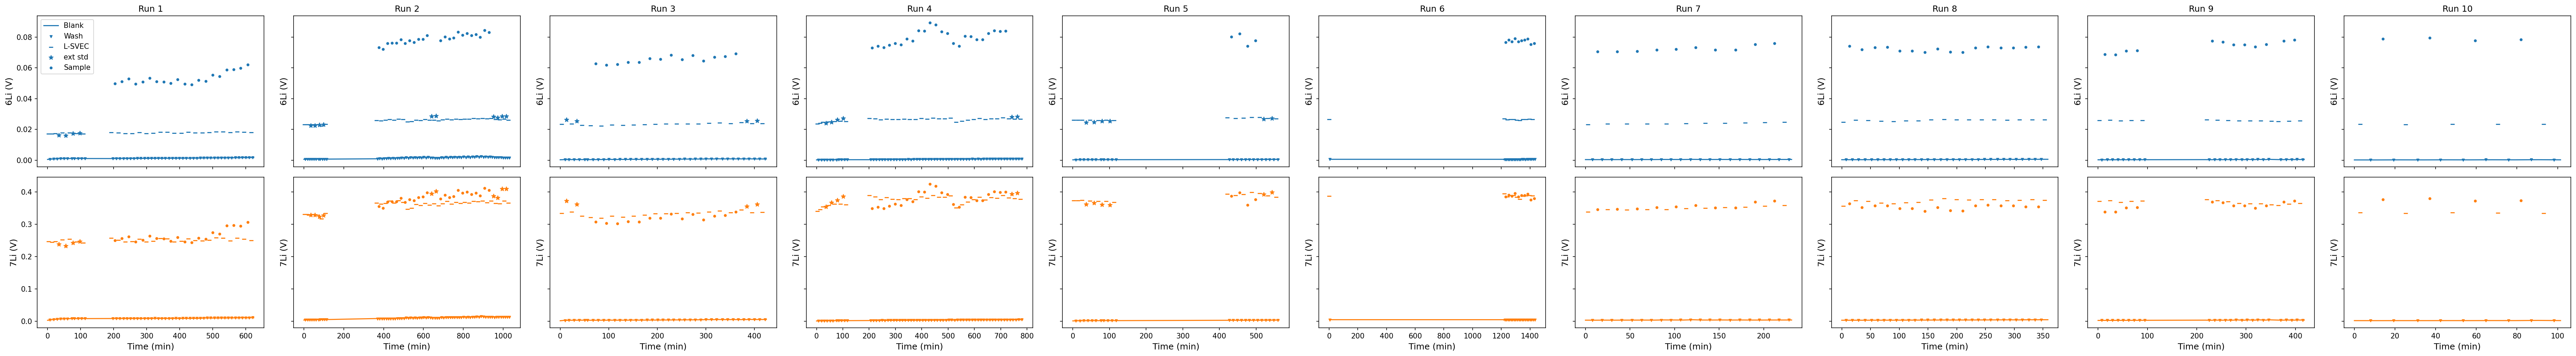

In [4]:
c6Li = 'C0'
c7Li = 'C1'
crLi = 'C2'
xvar = 'run_minutes'

nruns = int(nd.Run.max())

fig, axs = plt.subplots(2, nruns, figsize=(5 * nruns, 7), sharey='row', sharex='col')

for r in range(1, nruns + 1):
    snd = nd.loc[nd.Run == r]
    ax6, ax7 = axs[:, r-1]

    ax6.plot(snd.loc[iblank, xvar], snd.loc[iblank, '6Li'], c=c6Li, label='Blank')
    ax7.plot(snd.loc[iblank, xvar], snd.loc[iblank, '7Li'], c=c7Li)

    ax6.scatter(snd.loc[iwash, xvar], snd.loc[iwash, '6Li'], c=c6Li, s=10, marker='v', label='Wash')
    ax7.scatter(snd.loc[iwash, xvar], snd.loc[iwash, '7Li'], c=c7Li, s=10, marker='v')

    ax6.scatter(snd.loc[iLSVEC, xvar], snd.loc[iLSVEC, '6Li'], c=c6Li, marker='_', label='L-SVEC')
    ax7.scatter(snd.loc[iLSVEC, xvar], snd.loc[iLSVEC, '7Li'], c=c7Li, marker='_')

    ax6.scatter(snd.loc[iext, xvar], snd.loc[iext, '6Li'], c=c6Li, marker='*', label='ext std')
    ax7.scatter(snd.loc[iext, xvar], snd.loc[iext, '7Li'], c=c7Li, marker='*')
    
    ax6.scatter(snd.loc[isample, xvar], snd.loc[isample, '6Li'], c=c6Li, marker='.', label='Sample')
    ax7.scatter(snd.loc[isample, xvar], snd.loc[isample, '7Li'], c=c7Li, marker='.')

    ax6.set_ylabel('6Li (V)')
    ax7.set_ylabel('7Li (V)')
    
    ax6.set_title('Run {}'.format(r))
    ax7.set_xlabel('Time (min)')

axs[0, 0].legend()
    
fig.tight_layout()

# Blank Correction

In [5]:
blank_fwhm = 50

nd.loc[:, 'c6Li'] = 0
nd.loc[:, 'c7Li'] = 0

for r, g in nd.groupby('Run'):
    siblank = g.Sample == 'Blank'
    siwash = g.Sample == 'Wash'
    sisample = ~(siblank ^ siwash)

    bmean, bstd, bse = gauss_weighted_stats(g.loc[siblank, 'run_minutes'].values, 
                                            g.loc[siblank, ['6Li', '7Li']].values, 
                                            g.loc[sisample, 'run_minutes'].values, blank_fwhm)
    ublank = unp.uarray(bmean, bstd)

    nd.loc[(nd.Run == r) & ~(iblank ^ iwash), 'c6Li'] = g.loc[sisample, '6Li'] - ublank[0]
    nd.loc[(nd.Run == r) & ~(iblank ^ iwash), 'c7Li'] = g.loc[sisample, '7Li'] - ublank[1]

#     nd.loc[(nd.Run == r) & ~(iblank ^ iwash), 'c6Li'] = g.loc[sisample, '6Li'] - bmean[0]
#     nd.loc[(nd.Run == r) & ~(iblank ^ iwash), 'c7Li'] = g.loc[sisample, '7Li'] - bmean[1]

In [6]:
def errscat(x, y, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
        
    s = ax.scatter(x, nom(y), **kwargs)
    ax.errorbar(x, nom(y), std(y), lw=0, elinewidth=1, c=s.get_facecolor()[0])

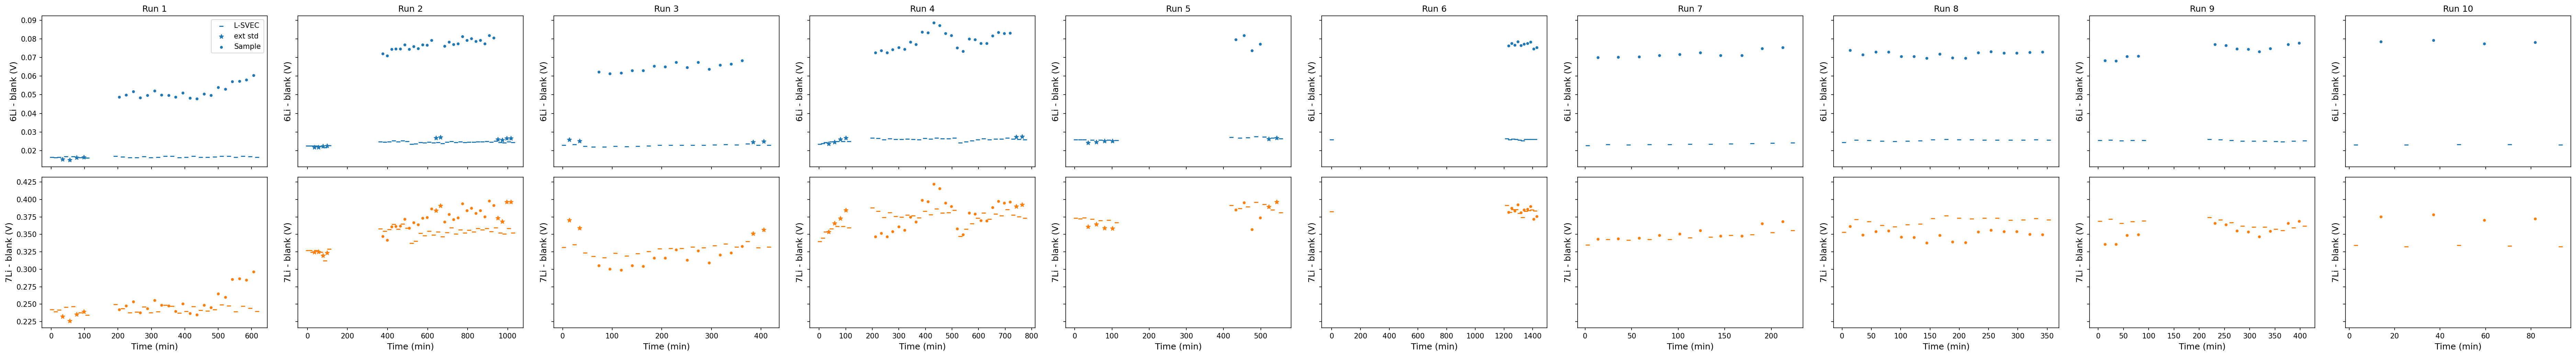

In [7]:
fig, axs = plt.subplots(2, nruns, figsize=(5 * nruns, 7), sharey='row', sharex='col')

for r in range(1, nruns + 1):
    snd = nd.loc[nd.Run == r]
    ax6, ax7 = axs[:, r-1]
    
    errscat(snd.loc[iLSVEC, xvar], snd.loc[iLSVEC, 'c6Li'], ax6, c=c6Li, marker='_', label='L-SVEC')
    errscat(snd.loc[iLSVEC, xvar], snd.loc[iLSVEC, 'c7Li'], ax7, c=c7Li, marker='_')
#     ax6.scatter(snd.loc[iLSVEC, xvar], nom(snd.loc[iLSVEC, 'c6Li']), c=c6Li, marker='_', label='L-SVEC')
#     ax7.scatter(snd.loc[iLSVEC, xvar], nom(snd.loc[iLSVEC, 'c7Li']), c=c7Li, marker='_')

    errscat(snd.loc[iext, xvar], snd.loc[iext, 'c6Li'], ax6, c=c6Li, marker='*', label='ext std')
    errscat(snd.loc[iext, xvar], snd.loc[iext, 'c7Li'], ax7, c=c7Li, marker='*')
#     ax6.scatter(snd.loc[iext, xvar], nom(snd.loc[iext, 'c6Li']), c=c6Li, marker='*', label='ext std')
#     ax7.scatter(snd.loc[iext, xvar], nom(snd.loc[iext, 'c7Li']), c=c7Li, marker='*')
    
    errscat(snd.loc[isample, xvar], snd.loc[isample, 'c6Li'], ax6, c=c6Li, marker='.', label='Sample')
    errscat(snd.loc[isample, xvar], snd.loc[isample, 'c7Li'], ax7, c=c7Li, marker='.')
#     ax6.scatter(snd.loc[isample, xvar], nom(snd.loc[isample, '6Li']), c=c6Li, marker='.', label='Sample')
#     ax7.scatter(snd.loc[isample, xvar], nom(snd.loc[isample, '7Li']), c=c7Li, marker='.')

    ax6.set_ylabel('6Li - blank (V)')
    ax7.set_ylabel('7Li - blank (V)')
    
    ax6.set_title('Run {}'.format(r))
    ax7.set_xlabel('Time (min)')

axs[0, 0].legend()

fig.tight_layout()

# Ratio Calculation

In [8]:
nd.loc[~(iblank ^ iwash), '7Li/6Li'] = nd.loc[~(iblank ^ iwash), 'c7Li'] / nd.loc[~(iblank ^ iwash), 'c6Li']

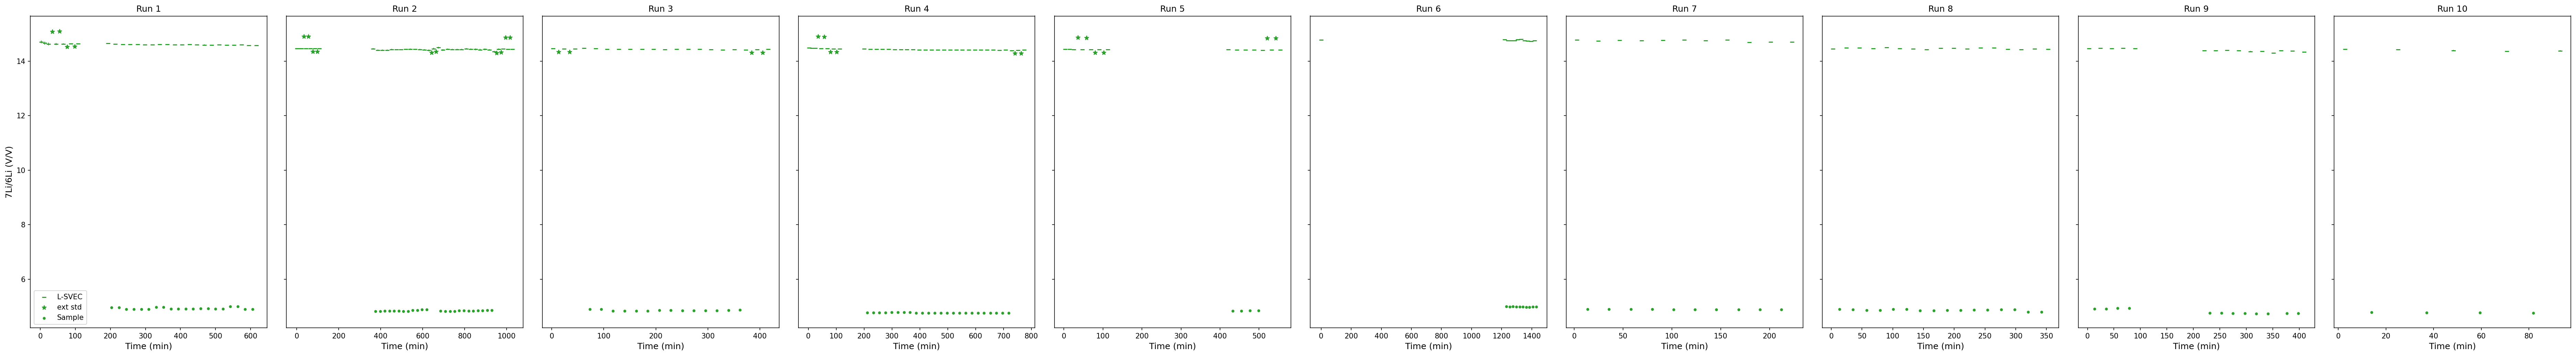

In [9]:
fig, axs = plt.subplots(1, nruns, figsize=(5 * nruns, 7), sharey='row', sharex='col')

for r in range(1, nruns + 1):
    snd = nd.loc[nd.Run == r]
    ax = axs[r-1]
    
    errscat(snd.loc[iLSVEC, xvar], snd.loc[iLSVEC, '7Li/6Li'], ax, c=crLi , marker='_', label='L-SVEC')
    errscat(snd.loc[iext, xvar], snd.loc[iext, '7Li/6Li'], ax, c=crLi , marker='*', label='ext std')
#     ax.scatter(snd.loc[iLSVEC, xvar], snd.loc[iLSVEC, '7Li/6Li'], c=crLi , marker='_', label='L-SVEC')
#     ax.scatter(snd.loc[iext, xvar], snd.loc[iext, '7Li/6Li'], c=crLi , marker='*', label='ext std')
    
    errscat(snd.loc[isample, xvar], snd.loc[isample, '7Li/6Li'], ax, c=crLi, marker='.', label='Sample')
#     ax.scatter(snd.loc[isample, xvar], snd.loc[isample, '7Li/6Li'], c=crLi, marker='.', label='Sample')

    ax.set_title('Run {}'.format(r))
    ax.set_xlabel('Time (min)')
    

axs[0].set_ylabel('7Li/6Li (V/V)')
axs[0].legend()

fig.tight_layout()

# Standardisation to LSVEC

In [10]:
blank_fwhm = 100

nd.loc[:, 'alpha_Sample-LSVEC'] = np.nan

for r, g in nd.groupby('Run'):
    siblank = g.Sample == 'Blank'
    siwash = g.Sample == 'Wash'
    siLSVEC = g.Sample.str.contains('SVEC')
    sisample = ~(siblank ^ siwash ^ siLSVEC)

    bmean, bstd, bse = gauss_weighted_stats(g.loc[siLSVEC, 'run_minutes'].values, 
                                            nom(g.loc[siLSVEC, '7Li/6Li'].values[:, np.newaxis]), 
                                            g.loc[sisample, 'run_minutes'].values, blank_fwhm)
    uLSVEC = unp.uarray(bmean, bstd)
    
    nd.loc[(nd.Run == r) & sisample, 'alpha_Sample-LSVEC'] = g.loc[sisample, '7Li/6Li'] / uLSVEC[0]
#     nd.loc[(nd.Run == r) & sisample, 'alpha_Sample-LSVEC'] = g.loc[sisample, '7Li/6Li'] / bmean[0]

In [11]:
nd.loc[:, 'delta_Sample-LSVEC'] = (nd.loc[:, 'alpha_Sample-LSVEC'] - 1) * 1000

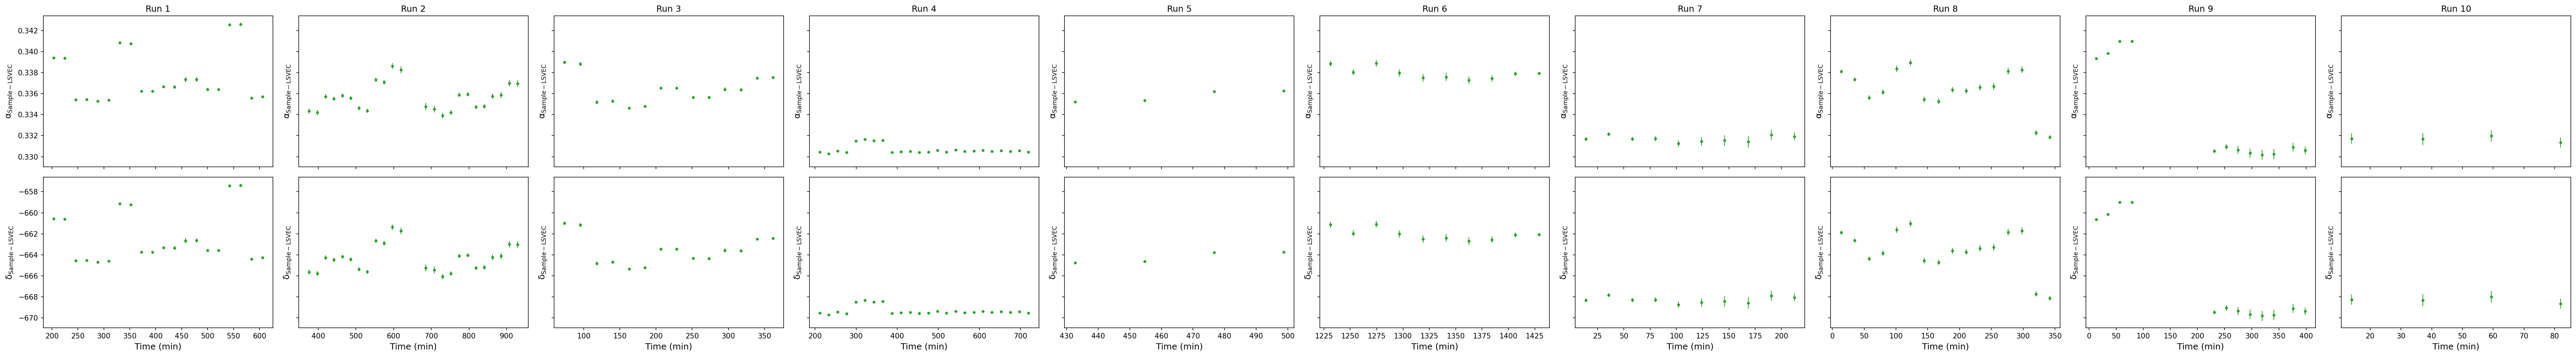

In [12]:
fig, axs = plt.subplots(2, nruns, figsize=(5 * nruns, 7), sharey='row', sharex='col')

for r in range(1, nruns + 1):
    snd = nd.loc[nd.Run == r]
    aax, dax = axs[:, r-1]
    
    errscat(snd.loc[isample, xvar], snd.loc[isample, 'alpha_Sample-LSVEC'], aax, c=crLi, marker='.')

    errscat(snd.loc[isample, xvar], snd.loc[isample, 'delta_Sample-LSVEC'], dax, c=crLi, marker='.')
    
#     aax.scatter(snd.loc[isample, xvar], snd.loc[isample, 'alpha_Sample-LSVEC'], c=crLi, marker='.')
#     dax.scatter(snd.loc[isample, xvar], snd.loc[isample, 'delta_Sample-LSVEC'], c=crLi, marker='.')

    aax.set_ylabel('$\\alpha_{Sample-LSVEC}$')
    dax.set_ylabel('$\\delta_{Sample-LSVEC}$')
    
    aax.set_title('Run {}'.format(r))
    dax.set_xlabel('Time (min)')

fig.tight_layout()

In [13]:
for k, d in nd.loc[isample, ['Sample','alpha_Sample-LSVEC','delta_Sample-LSVEC']].groupby('Sample'):
    pass

### External Standards

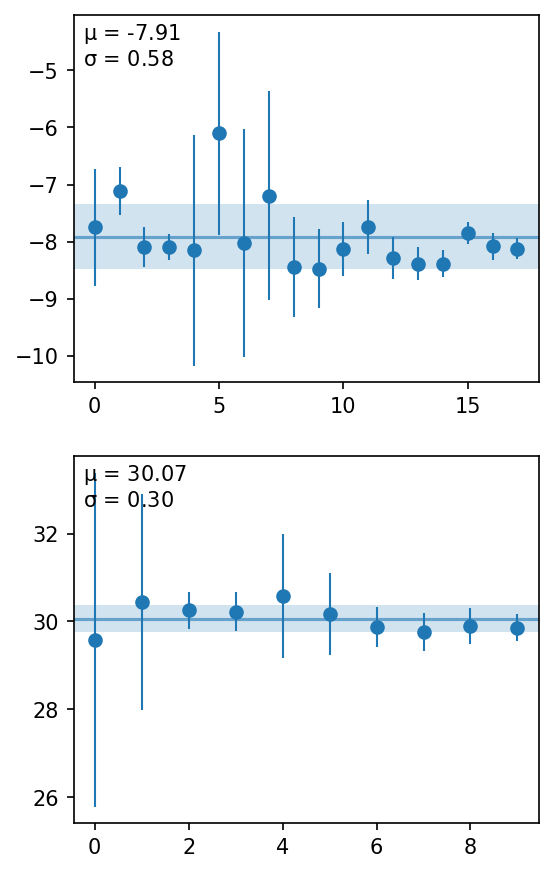

In [14]:
ext = nd.loc[iext]

fig, axs = plt.subplots(2, 1, figsize=[4, 7])

for ax, exstd in zip(axs, ['6Li ext std', '7Li ext std']):
    ind = ext.Sample == exstd
    x = np.arange(sum(ind))
    ax.errorbar(x, nom(ext.loc[ind, 'delta_Sample-LSVEC']), std(ext.loc[ind, 'delta_Sample-LSVEC']), lw=0, elinewidth=1, marker='o')
    
    mu = np.mean(nom(ext.loc[ind, 'delta_Sample-LSVEC']))
    err = np.std(nom(ext.loc[ind, 'delta_Sample-LSVEC']))
    ax.axhline(mu, alpha=0.6)
    ax.axhspan(mu - err, mu + err, alpha=0.2)
    
    ax.text(.02, .98, f'$\mu$ = {mu:.2f}\n$\sigma$ = {err:.2f}', transform=ax.transAxes, va='top')

## Think about this

In [15]:
# # correction factors (based on instrumental standard offsets)
# cf = {1: -1,
#       6: -1.2,
#       7: -0.5}

# for group, factor in cf.items():
#     nd.loc[nd.loc[:, 'Run'] == group, 'delta_Sample-LSVEC'] += factor
    
# nd.loc[:, 'alpha_Sample-LSVEC'] = nd.loc[:, 'delta_Sample-LSVEC'] / 1000 + 1

In [16]:
def mean(d):
    return np.mean(d.values)

sam = nd.loc[isample, ['Sample','alpha_Sample-LSVEC','delta_Sample-LSVEC']].groupby('Sample').aggregate([mean, len])

## Format Data for Export

In [17]:
sam_alpha = nd.loc[isample, ['Sample','alpha_Sample-LSVEC']].groupby('Sample').aggregate([mean, len])

sam_alpha.loc[:, ('Li_isotopes_alpha_LSVEC', 'solid')] = unp.nominal_values(sam_alpha.loc[:, ('alpha_Sample-LSVEC', 'mean')])
sam_alpha.loc[:, ('Li_isotopes_alpha_LSVEC', 'solid_std')] = unp.std_devs(sam_alpha.loc[:, ('alpha_Sample-LSVEC', 'mean')])
sam_alpha.drop('alpha_Sample-LSVEC', axis=1, inplace=True)

### Isolate Fluids

In [18]:
iliq = sam.index.str.contains('pre') | sam.index.str.contains('post')
isol = ~iliq

experiments = sam.loc[isol].index
solids = sam.loc[isol]
rsolns = sam.loc[iliq]

# parse out pre/post experiment solution measurements
solns = pd.DataFrame(columns=pd.MultiIndex.from_product([sam.columns.levels[0], ['pre', 'post']]))

parse_name = re.compile('(C?[0-9].[0-9]) ?([preost]+)')
for k, r in rsolns.iterrows():
    cond, prepost = parse_name.match(k).groups()
    vals = r.loc[idx[:, 'mean']]

    solns.loc[cond, idx[:, prepost]] = vals.values

In [19]:
for p in ['pre', 'post']:
    solns.loc[:, ('Li_isotopes_alpha_LSVEC', 'fluid_' + p)] = unp.nominal_values(solns.loc[:, ('alpha_Sample-LSVEC', p)])
    solns.loc[:, ('Li_isotopes_alpha_LSVEC', 'fluid_' + p + '_std')] = unp.std_devs(solns.loc[:, ('alpha_Sample-LSVEC', p)])

In [20]:
sam_alpha = sam_alpha.join(solns.loc[:, idx['Li_isotopes_alpha_LSVEC', :]])

In [21]:
sam_alpha.loc[sam_alpha.index.str.contains('pre')]

Li_isotopes_alpha_LSVEC                                               \
                           solid solid_std fluid_pre fluid_pre_std fluid_post   
Sample                                                                          
1.1 pre                 0.330446  0.000039       NaN           NaN        NaN   
2.1 pre                 0.330524  0.000032       NaN           NaN        NaN   
3.1 pre                 0.330511  0.000027       NaN           NaN        NaN   
4.1 pre                 0.330553  0.000040       NaN           NaN        NaN   
5.1pre                  0.330730  0.000166       NaN           NaN        NaN   
6.1pre                  0.330211  0.000341       NaN           NaN        NaN   
7.1pre                  0.331705  0.000376       NaN           NaN        NaN   
8.1pre                  0.332065  0.000160       NaN           NaN        NaN   
8.2 pre                 0.331481  0.000364       NaN           NaN        NaN   
C1.1 pre                0.330359  0.000040       NaN           NaN        NaN   
C2.1 pre                0.331577  0.000042       NaN           NaN        NaN   
C2.3 pre                0.331918  0.000130       NaN           NaN        NaN   

                         
         fluid_post_std  
Sample                   
1.1 pre             NaN  
2.1 pre             NaN  
3.1 pre             NaN  
4.1 pre             NaN  
5.1pre              NaN  
6.1pre              NaN  
7.1pre              NaN  
8.1pre              NaN  
8.2 pre             NaN  
C1.1 pre            NaN  
C2.1 pre            NaN  
C2.3 pre            NaN

In [22]:
sam_alpha = sam_alpha.loc[~(sam_alpha.index.str.contains('post') | sam_alpha.index.str.contains('pre'))]

sam_alpha.to_csv('data/processed_Neptune.csv')

## Standardise to solution

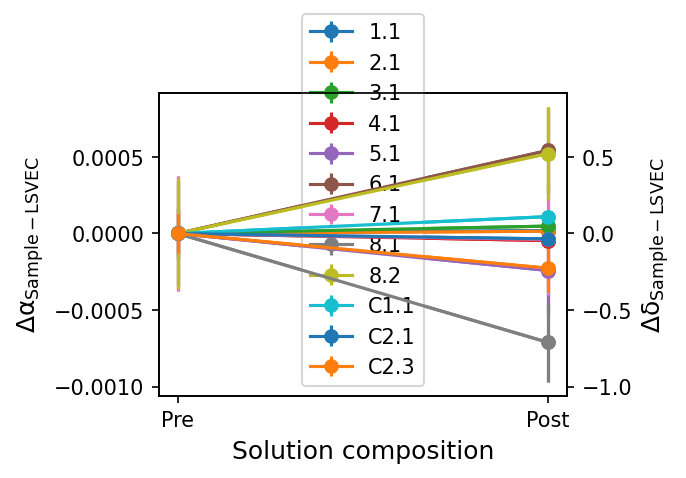

In [23]:
fig, aax = plt.subplots(1, 1)

dax = aax.twinx()

for k, r in solns.iterrows():
    alpha = r.loc['alpha_Sample-LSVEC']
    delta = r.loc['delta_Sample-LSVEC']
    aax.errorbar([0, 1], nom(alpha) - nom(alpha.pre), std(alpha), marker='o', label=k)
    dax.errorbar([0, 1], nom(delta) - nom(delta.pre), std(delta), marker='o', label=k)

aax.legend()

aax.set_ylabel('$\\Delta \\alpha_{Sample-LSVEC}$')
dax.set_ylabel('$\\Delta \\delta_{Sample-LSVEC}$')

aax.set_xticks([0, 1])
aax.set_xticklabels(['Pre', 'Post'])
aax.set_xlabel('Solution composition')

fig.tight_layout()

In [24]:
# split index into useful multiindex
solids.index = pd.MultiIndex.from_tuples([(c, r) for c, r in solids.index.str.split('.')], names=['condition', 'replicate'])
solns.index = pd.MultiIndex.from_tuples([(c, r) for c, r in solns.index.str.split('.')], names=['condition', 'replicate'])

In [25]:
# calculate means
solns.loc[:, ('alpha_Sample-LSVEC', 'mean')] = solns.loc[:, 'alpha_Sample-LSVEC'].values.mean(1)
solns.loc[:, ('delta_Sample-LSVEC', 'mean')] = solns.loc[:, 'delta_Sample-LSVEC'].values.mean(1)
solns.sort_index(1, inplace=True)

In [26]:
solids.loc[:, ('alpha_Sample-LSVEC', 'soln')] = solns.loc[:, ('alpha_Sample-LSVEC', 'mean')]

# fill missing values with mean of all others
# solids.loc[idx[:, '1'], ('alpha_Sample-LSVEC', 'soln')] = np.nanmean(solids.loc[idx[:, '1'], ('alpha_Sample-LSVEC', 'soln')])

# forward-fill solution values
solids.loc[:, ('alpha_Sample-LSVEC', 'soln')].ffill(inplace=True)

solids = solids.loc[['1', '2', '3', '4', 'C1', 'C2']]  # remove experiments without solution measurements

In [27]:
solids['alpha_Sample-Solution'] = solids[('alpha_Sample-LSVEC', 'mean')] / solids[('alpha_Sample-LSVEC', 'soln')]
solids['delta_Sample-Solution']  = (solids['alpha_Sample-Solution'] - 1) * 1000

## Uncertainty Sources Graph

In [28]:
from scipy import stats

In [29]:
# solids.apply(nom).to_csv('my_method.csv')

Text(0, 0.5, '$\\delta^7Li_{Sample-Fluid}$')

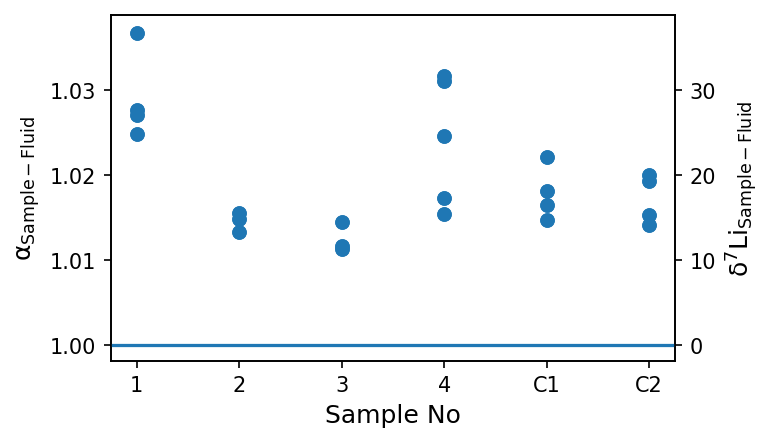

In [30]:
plt.errorbar(solids.index.get_level_values(0), nom(solids.loc[:, 'alpha_Sample-Solution']), std(solids.loc[:, 'alpha_Sample-Solution']), marker='o', lw=0, elinewidth=1)
plt.axhline(1)
plt.ylabel('$\\alpha_{Sample-Fluid}$')
plt.xlabel('Sample No')

ax2 = plt.gca().twinx()
ax2.errorbar(solids.index.get_level_values(0), nom(solids.loc[:, 'delta_Sample-Solution']), std(solids.loc[:, 'delta_Sample-Solution']), marker='o', lw=0, elinewidth=1)
ax2.axhline(0)
ax2.set_ylabel('$\\delta^7Li_{Sample-Fluid}$')

(-672.0, -654.0)

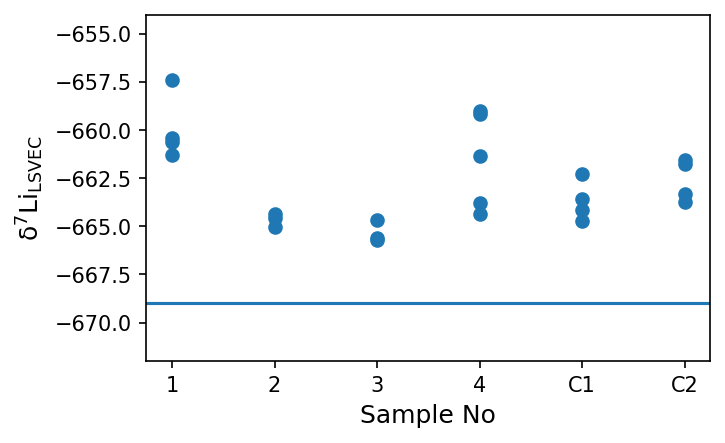

In [31]:
plt.errorbar(solids.index.get_level_values(0), nom(solids.loc[:, ('delta_Sample-LSVEC', 'mean')]), std(solids.loc[:, ('delta_Sample-LSVEC', 'mean')]), marker='o', lw=0, elinewidth=1)
plt.axhline(nom(np.mean(solns.loc[:, ('delta_Sample-LSVEC', 'mean')].values)))
plt.ylabel('$\\delta^7Li_{LSVEC}$')
plt.xlabel('Sample No')

plt.ylim(-672, -654)

<ErrorbarContainer object of 3 artists>

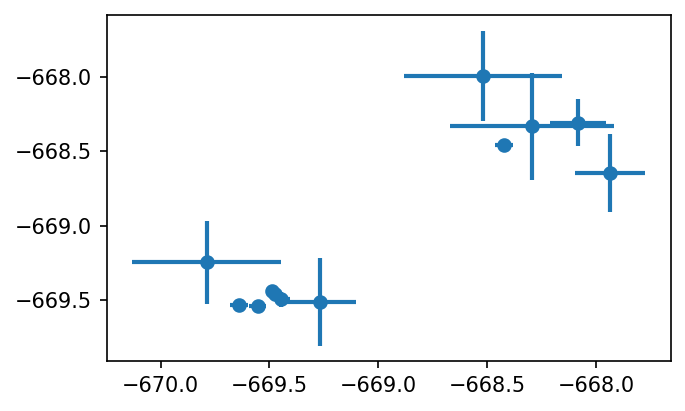

In [32]:
plt.errorbar(nom(solns.loc[:, ('delta_Sample-LSVEC', 'pre')]), nom(solns.loc[:, ('delta_Sample-LSVEC', 'post')]),
             xerr=std(solns.loc[:, ('delta_Sample-LSVEC', 'pre')]), yerr=std(solns.loc[:, ('delta_Sample-LSVEC', 'post')]),
             lw=0, elinewidth=2, marker='o')

<ErrorbarContainer object of 3 artists>

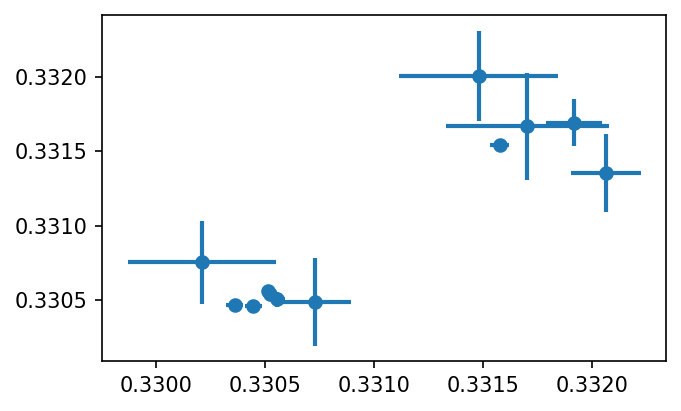

In [33]:
plt.errorbar(nom(solns.loc[:, ('alpha_Sample-LSVEC', 'pre')]), nom(solns.loc[:, ('alpha_Sample-LSVEC', 'post')]),
             xerr=std(solns.loc[:, ('alpha_Sample-LSVEC', 'pre')]), yerr=std(solns.loc[:, ('alpha_Sample-LSVEC', 'post')]),
             lw=0, elinewidth=2, marker='o')

In [34]:
np.mean(solns[('delta_Sample-LSVEC', 'pre')].values)

-668.9932704793054+/-0.057026939163685626

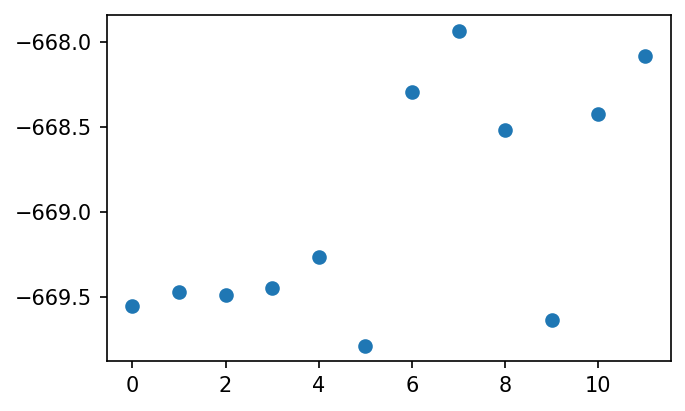

In [35]:
plt.scatter(np.arange(solns.shape[0]), nom(solns[('delta_Sample-LSVEC', 'pre')]))